In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr

SEED = 350107321 # from random.org
np.random.seed(SEED)

In [4]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [5]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [6]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<Container object of 3 artists>

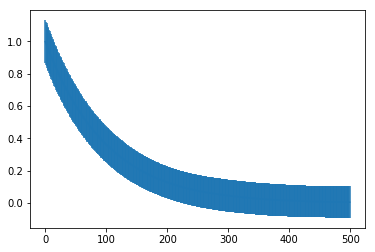

In [7]:
plt.errorbar(t,acf_mean,yerr=acf_std)

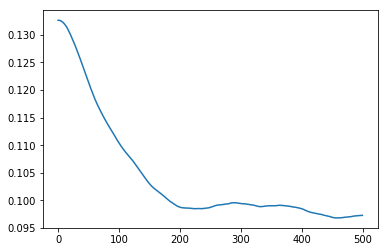

In [8]:
plt.plot(t,acf_std)

In [9]:
acf_all[0].size

500

In [10]:
result_array = None
for y in acf_all:
    print("***** Iteration ",i," *****")
    mod = ExponentialModel()
    pars = mod.guess(y, x=t)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            np.sqrt(out.covar[1,1])*delta_t,
                            out.values['amplitude'],
                            np.sqrt(out.covar[0,0])])
        print(out.fit_report(min_correl=0.25))
        
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            np.sqrt(out2.covar[1,1])*delta_t,
                            out2.values['amplitude'],
                            np.sqrt(out2.covar[0,0])])
        print(out2.fit_report(min_correl=0.25))

    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.380
    reduced chi-square = 0.001
    Akaike info crit   = -3587.712
    Bayesian info crit = -3579.283
[[Variables]]
    decay:       99.3939795 +/- 0.959985 (0.97%) (init= 92.62367)
    amplitude:   0.80861652 +/- 0.005487 (0.68%) (init= 0.9128493)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 36.892
    reduced chi-square = 0.074
    Akaike info crit   = -1299.308
    Bayesian info crit = -1290.879
[[Variables]]
    decay:       101.268806 +/- 1.056128 (1.04%) (init= 92.62367)
    amplitude:   0.79842634 +/- 0.006695 (0.84%) (init= 0.9128493)
[[Correlations]] (unreported correlations


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 50.336
    reduced chi-square = 0.101
    Akaike info crit   = -1143.940
    Bayesian info crit = -1135.511
[[Variables]]
    decay:       161.689198 +/- 1.721365 (1.06%) (init= 223.4306)
    amplitude:   0.74111215 +/- 0.006170 (0.83%) (init= 0.5623251)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.746 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.402
    reduced chi-square = 0.001
    Akaike info crit   = -3558.440
    Bayesian info crit = -3550.011
[[Variables]]
    decay:       102.603393 +/- 0.964268 (0.94%) (init= 130.5466)
    amplitude:   0.84285128 +/- 0.005564 (0.66%) (init= 0.6350753)
[[Correlations]] (unreported correlation


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 84.234
    reduced chi-square = 0.169
    Akaike info crit   = -886.502
    Bayesian info crit = -878.073
[[Variables]]
    decay:       100.397717 +/- 0.997342 (0.99%) (init= 140.3718)
    amplitude:   1.27250165 +/- 0.010162 (0.80%) (init= 0.8691822)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.722 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.503
    reduced chi-square = 0.001
    Akaike info crit   = -3446.650
    Bayesian info crit = -3438.221
[[Variables]]
    decay:       87.2217023 +/- 0.932901 (1.07%) (init= 100.8726)
    amplitude:   0.89560726 +/- 0.006732 (0.75%) (init= 0.7318508)
[[Correlations]] (unreported correlations 


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 210.714
    reduced chi-square = 0.423
    Akaike info crit   = -428.054
    Bayesian info crit = -419.625
[[Variables]]
    decay:       82.3175424 +/- 1.787498 (2.17%) (init= 205.4888)
    amplitude:   1.02836163 +/- 0.017838 (1.73%) (init= 0.3541994)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.715 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.281
    reduced chi-square = 0.003
    Akaike info crit   = -2979.537
    Bayesian info crit = -2971.108
[[Variables]]
    decay:       70.6132559 +/- 1.317095 (1.87%) (init= 222.4791)
    amplitude:   0.90886722 +/- 0.011901 (1.31%) (init= 0.1930907)
[[Correlations]] (unreported correlations

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 4.128
    reduced chi-square = 0.008
    Akaike info crit   = -2394.447
    Bayesian info crit = -2386.018
[[Variables]]
    decay:       86.8320449 +/- 1.893725 (2.18%) (init= 214.8094)
    amplitude:   1.26061347 +/- 0.019323 (1.53%) (init= 0.4310721)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 415.129
    reduced chi-square = 0.834
    Akaike info crit   = -89.010
    Bayesian info crit = -80.580
[[Variables]]
    decay:       84.1662521 +/- 2.019622 (2.40%) (init= 214.8094)
    amplitude:   1.28950509 +/- 0.024750 (1.92%) (init= 0.4310721)
[[Correlations]] (unreported correlations ar


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 68.474
    reduced chi-square = 0.137
    Akaike info crit   = -990.075
    Bayesian info crit = -981.646
[[Variables]]
    decay:       109.667673 +/- 1.034521 (0.94%) (init= 89.07448)
    amplitude:   1.15327914 +/- 0.008749 (0.76%) (init= 1.300997)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.726 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.996
    reduced chi-square = 0.002
    Akaike info crit   = -3105.123
    Bayesian info crit = -3096.694
[[Variables]]
    decay:       98.4719330 +/- 1.030826 (1.05%) (init= 100.7644)
    amplitude:   1.21429865 +/- 0.008931 (0.74%) (init= 0.9596389)
[[Correlations]] (unreported correlations a

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 1.576
    reduced chi-square = 0.003
    Akaike info crit   = -2875.729
    Bayesian info crit = -2867.300
[[Variables]]
    decay:       93.2042444 +/- 1.370106 (1.47%) (init= 161.2338)
    amplitude:   1.11680723 +/- 0.011537 (1.03%) (init= 0.5364381)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 160.736
    reduced chi-square = 0.323
    Akaike info crit   = -563.423
    Bayesian info crit = -554.994
[[Variables]]
    decay:       91.5358386 +/- 1.484025 (1.62%) (init= 161.2338)
    amplitude:   1.13286981 +/- 0.014736 (1.30%) (init= 0.5364381)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 58.970
    reduced chi-square = 0.118
    Akaike info crit   = -1064.793
    Bayesian info crit = -1056.364
[[Variables]]
    decay:       109.246521 +/- 1.080175 (0.99%) (init= 181.8277)
    amplitude:   1.02311884 +/- 0.008136 (0.80%) (init= 0.603016)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.725 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 1.091
    reduced chi-square = 0.002
    Akaike info crit   = -3059.784
    Bayesian info crit = -3051.355
[[Variables]]
    decay:       141.155000 +/- 2.206001 (1.56%) (init= 219.4712)
    amplitude:   0.72616430 +/- 0.007888 (1.09%) (init= 0.5066771)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 3.111
    reduced chi-square = 0.006
    Akaike info crit   = -2535.837
    Bayesian info crit = -2527.407
[[Variables]]
    decay:       143.778278 +/- 3.181688 (2.21%) (init= 296.4557)
    amplitude:   0.86019632 +/- 0.013209 (1.54%) (init= 0.4985786)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.711 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 30
    # data points      = 500
    # variables        = 2
    chi-square         = 296.053
    reduced chi-square = 0.594
    Akaike info crit   = -258.034
    Bayesian info crit = -249.605
[[Variables]]
    decay:       158.026444 +/- 3.795129 (2.40%) (init= 296.4557)
    amplitude:   0.80276004 +/- 0.015131 (1.88%) (init= 0.4985786)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, a

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 0.351
    reduced chi-square = 0.001
    Akaike info crit   = -3627.407
    Bayesian info crit = -3618.978
[[Variables]]
    decay:       147.022149 +/- 0.779480 (0.53%) (init= 156.451)
    amplitude:   1.19525553 +/- 0.004390 (0.37%) (init= 1.076826)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.711 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 34.322
    reduced chi-square = 0.069
    Akaike info crit   = -1335.411
    Bayesian info crit = -1326.982
[[Variables]]
    decay:       145.974142 +/- 0.820195 (0.56%) (init= 156.451)
    amplitude:   1.20266148 +/- 0.005354 (0.45%) (init= 1.076826)
[[Correlations]] (unreported correlations are


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 61.216
    reduced chi-square = 0.123
    Akaike info crit   = -1046.100
    Bayesian info crit = -1037.671
[[Variables]]
    decay:       106.697346 +/- 1.188185 (1.11%) (init= 172.3457)
    amplitude:   0.93700216 +/- 0.008392 (0.90%) (init= 0.5432417)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.724 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.856
    reduced chi-square = 0.006
    Akaike info crit   = -2578.631
    Bayesian info crit = -2570.202
[[Variables]]
    decay:       96.3691629 +/- 1.664785 (1.73%) (init= 174.2161)
    amplitude:   1.25873015 +/- 0.015279 (1.21%) (init= 0.7232452)
[[Correlations]] (unreported correlation

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 0.543
    reduced chi-square = 0.001
    Akaike info crit   = -3408.453
    Bayesian info crit = -3400.024
[[Variables]]
    decay:       83.9268226 +/- 0.989316 (1.18%) (init= 127.0614)
    amplitude:   0.86034815 +/- 0.007126 (0.83%) (init= 0.4772468)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 53.719
    reduced chi-square = 0.108
    Akaike info crit   = -1111.422
    Bayesian info crit = -1102.992
[[Variables]]
    decay:       82.5236607 +/- 1.066261 (1.29%) (init= 127.0614)
    amplitude:   0.87126892 +/- 0.008995 (1.03%) (init= 0.4772468)
[[Correlations]] (unreported correlations


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 0.745
    reduced chi-square = 0.001
    Akaike info crit   = -3250.698
    Bayesian info crit = -3242.268
[[Variables]]
    decay:       73.6706843 +/- 0.974876 (1.32%) (init= 170.0986)
    amplitude:   0.95665829 +/- 0.008889 (0.93%) (init= 0.2459454)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 73.708
    reduced chi-square = 0.148
    Akaike info crit   = -953.246
    Bayesian info crit = -944.817
[[Variables]]
    decay:       72.0115172 +/- 1.060189 (1.47%) (init= 170.0986)
    amplitude:   0.96927451 +/- 0.011317 (1.17%) (init= 0.2459454)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 0.811
    reduced chi-square = 0.002
    Akaike info crit   = -3208.344
    Bayesian info crit = -3199.915
[[Variables]]
    decay:       72.0133859 +/- 0.921252 (1.28%) (init= 113.8484)
    amplitude:   1.04391470 +/- 0.009378 (0.90%) (init= 0.2931314)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 75.508
    reduced chi-square = 0.152
    Akaike info crit   = -941.183
    Bayesian info crit = -932.753
[[Variables]]
    decay:       69.7387823 +/- 0.964415 (1.38%) (init= 113.8484)
    amplitude:   1.06414679 +/- 0.011648 (1.09%) (init= 0.2931314)
[[Correlations]] (unreported correlations a

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.231
    reduced chi-square = 0.000
    Akaike info crit   = -3835.381
    Bayesian info crit = -3826.952
[[Variables]]
    decay:       89.2710796 +/- 0.587772 (0.66%) (init= 108.8604)
    amplitude:   0.97520239 +/- 0.004512 (0.46%) (init= 0.7848575)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 23.246
    reduced chi-square = 0.047
    Akaike info crit   = -1530.236
    Bayesian info crit = -1521.807
[[Variables]]
    decay:       89.4488534 +/- 0.650517 (0.73%) (init= 108.8604)
    amplitude:   0.97289348 +/- 0.005672 (0.58%) (init= 0.7848575)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, 

Least Square fit tau std 0.391973992338
Least Square fit dtau mean 0.000114396392235
Least Square fit tau weights std 0.438253657284
Least Square fit dtau weights mean 0.00014267716565
bayesian tau std 0.133071096251


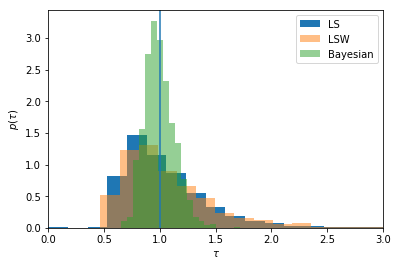

In [11]:
# decay time
plt.hist(result_array.T[0],normed=True,bins=20,label="LS")
plt.hist(result_array.T[4],normed=True,alpha=0.5,bins=20,label="LSW")
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.5,bins=20,label="Bayesian")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))

print("Least Square fit tau std",result_array.T[0].std())
print("Least Square fit dtau mean",result_array.T[1].mean())
print("Least Square fit tau weights std", result_array.T[4].std())
print("Least Square fit dtau weights mean",result_array.T[5].mean())
print("bayesian tau std",result_Bayes_array.T[2].std())

(0.31571697413121708, 1.3926890159658093e-24)


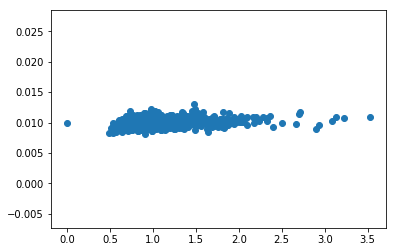

In [12]:
plt.scatter(result_array.T[0],result_Bayes_array.T[1])
print(pearsonr(result_array.T[0],result_Bayes_array.T[1]))

(0.28342056248244785, 6.2810329368515817e-20)


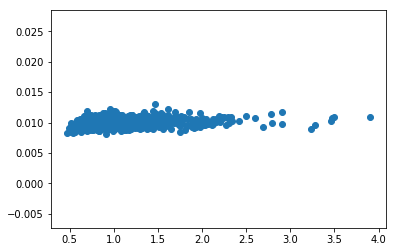

In [13]:
plt.scatter(result_array.T[4],result_Bayes_array.T[1])
print(pearsonr(result_array.T[4],result_Bayes_array.T[1]))

Least Square fit sigma^2 std 0.164866374075
Least Square fit dsigma^2 mean 1.64658232363
Least Square fit sigma^2 weights std 0.175921003812
Least Square fit dsigma^2 weights mean 1.82667150402
bayesian sigma^2 std 0.131827476656


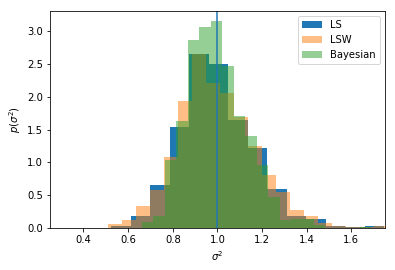

In [14]:
# amplitude
plt.hist(result_array.T[2],normed=True,bins=20,label="LS")
plt.hist(result_array.T[6],normed=True,alpha=0.5,bins=20,label="LSW")
plt.hist(result_Bayes_array.T[0],normed=True,alpha=0.5,bins=20,label="Bayesian")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\sigma^2$")
plt.ylabel(r"$p(\sigma^{2})$")

plt.xlim((0.25,1.75))
print("Least Square fit sigma^2 std",result_array.T[2].std())
print("Least Square fit dsigma^2 mean",result_array.T[3].mean())
print("Least Square fit sigma^2 weights std", result_array.T[6].std())
print("Least Square fit dsigma^2 weights mean",result_array.T[7].mean())
print("bayesian sigma^2 std",result_Bayes_array.T[0].std())

(0.82253806150040476, 7.379633728334064e-247)


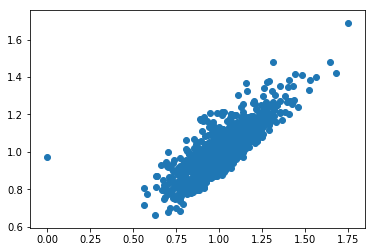

In [15]:
plt.scatter(result_array.T[2],result_Bayes_array.T[0])
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))

(0.77301983439930744, 1.8190017769651161e-199)


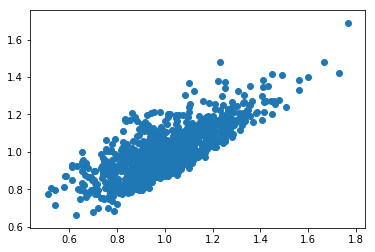

In [16]:
plt.scatter(result_array.T[6],result_Bayes_array.T[0])
print(pearsonr(result_array.T[6],result_Bayes_array.T[0]))